<a href="https://colab.research.google.com/github/Francisco-Guillen/SkinCancerDetector/blob/main/Skin_Cancer_Model_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conv2D: This is the 2D convolution layer. It creates a kernel that is convolved with the input to produce an output tensor through convolution. This layer is often used to extract features from images.

MaxPooling2D: This is the 2D maximum pooling layer. It performs the maximum pooling operation to reduce the spatial dimensionality of the input, resulting in an output volume.

Dense: This is the dense layer, also known as the fully connected layer. It connects each input neuron to each output neuron in the next layer.

Flatten: This is a flattening layer that transforms the input data into a one-dimensional vector (flatten). It is generally used to transition between convolutional and dense layers in convolutional neural networks.

Dropout: This is a dropout layer that helps reduce overfitting by randomly switching off a specified number of input units during training.

EarlyStopping: This callback is used to stop training if a certain monitored metric does not improve for a specific number of consecutive epochs. This is useful for avoiding overfitting and saving computing time by stopping training when there are no longer significant gains.

ModelCheckpoint: This callback is used to save the model during training. You can specify when to save the model based on a specific metric or every epoch. This is useful to ensure that you have a version of the model with the best performance during training.

ReduceLROnPlateau: This callback is used to reduce the learning rate when a monitored metric stops improving. This is useful to help the model converge more quickly to the global minimum during training, especially if it is close to the global minimum but the oscillation of the loss function is high.



confusion_matrix: The confusion_matrix function is used to calculate the confusion matrix, which is a table showing how often instances of each class are classified correctly or incorrectly by the model. The rows represent the actual classes and the columns represent the classes predicted by the model.

classification_report: The classification_report function is used to generate a classification report that includes various model evaluation metrics, such as precision, recall, F1 score and support, for each class and for the dataset as a whole. This provides a more detailed view of the model's performance beyond the confusion matrix.

These 2 functions are useful to better understand how the model is performing in different classes and to identify possible problems, such as class imbalance, overfitting or underfitting

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting path of directory
Basal_Cell_Carcinoma_DIR = "/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Train/"
Melanoma_DIR =  "/content/drive/MyDrive/Training_Input/Melanoma/Train2/"
Nevus_DIR = "/content/drive/MyDrive/Training_Input/Nevus/Train/"


# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Bimages = os.listdir(Basal_Cell_Carcinoma_DIR)
Mimages = os.listdir(Melanoma_DIR)
Nimages = os.listdir(Nevus_DIR)

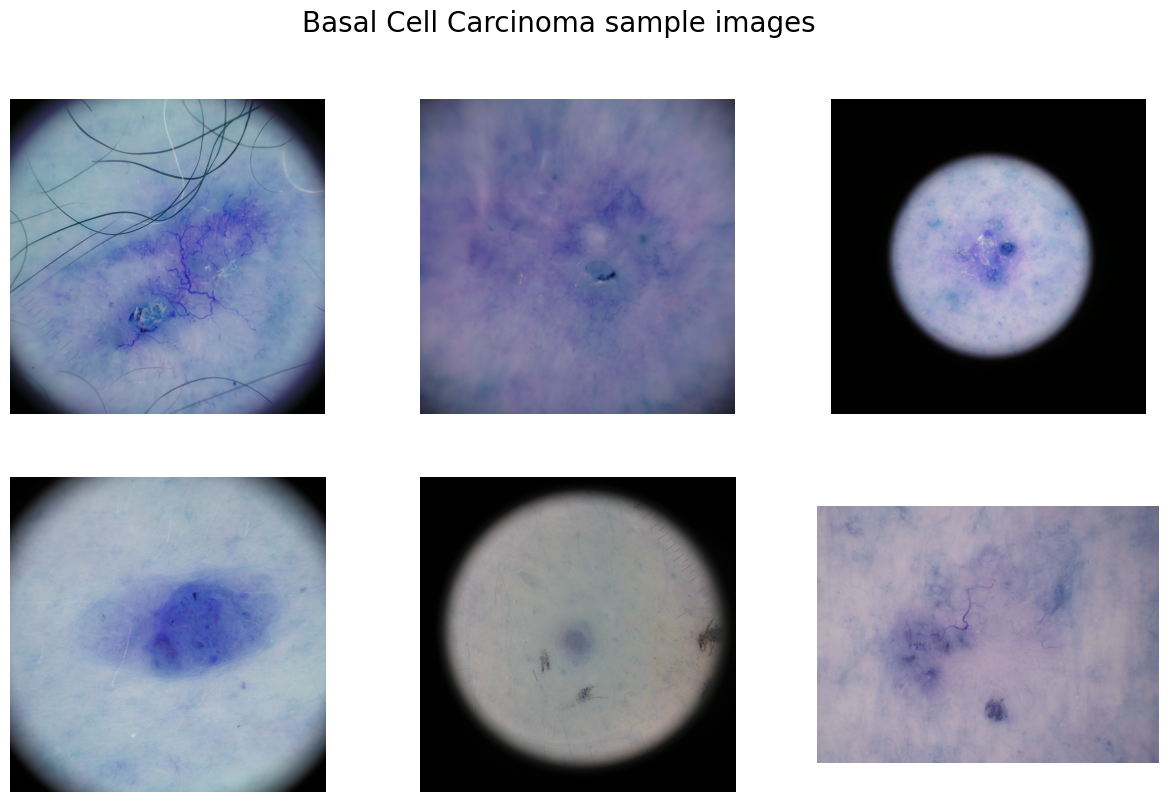

In [ ]:
sample_parasite = random.sample(Bimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread("/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Train/" +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Basal Cell Carcinoma sample images',fontsize=20)
plt.show()

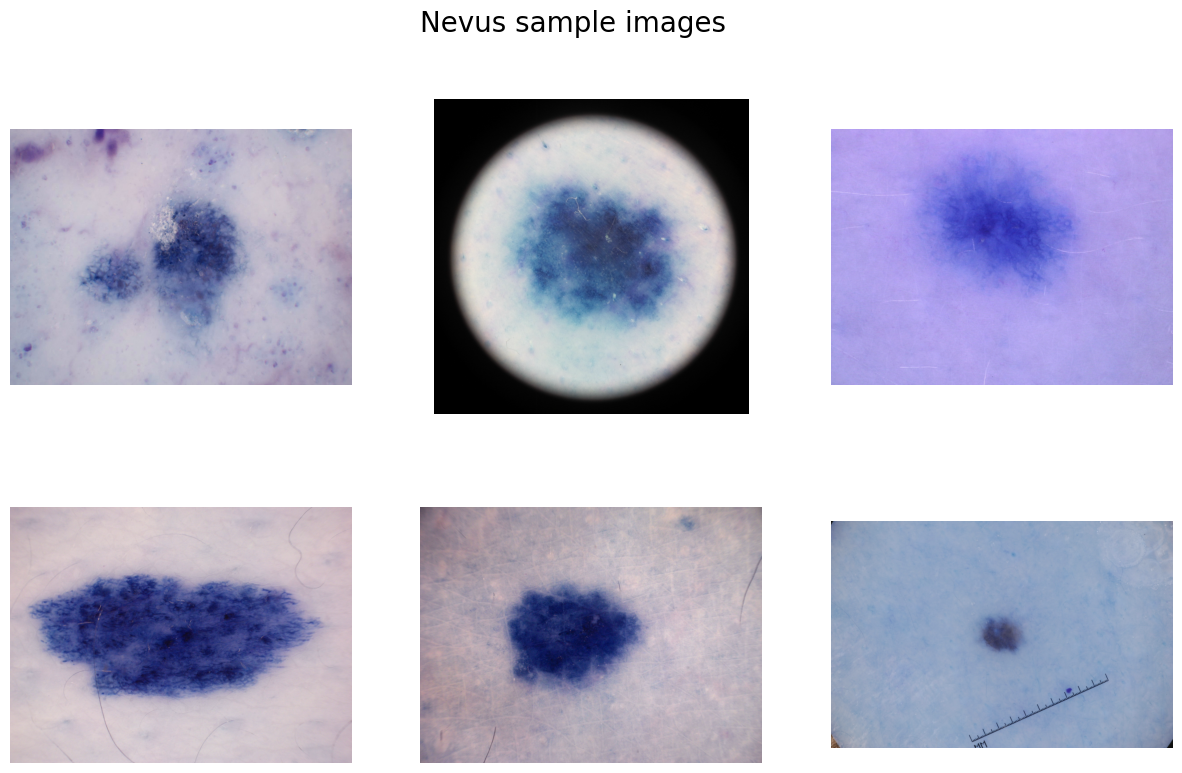

In [ ]:
sample_parasite = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(N_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Nevus sample images',fontsize=20)
plt.show()

# Data Preparation

In [ ]:
data=[]
labels=[]
Basal=os.listdir("/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Train/")
for a in Basal:
    try:
        image=cv2.imread("/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Train/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/MyDrive/Training_Input/Melanoma/Train2/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/MyDrive/Training_Input/Melanoma/Train2/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/MyDrive/Training_Input/Nevus/Train/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/MyDrive/Training_Input/Nevus/Train/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [ ]:
# Converting features and labels in array
feats=np.array(data)
labels=np.array(labels)
# Saving features and labels for later
np.save("/content/drive/MyDrive/Training_Input/feats_train",feats)
np.save("/content/drive/MyDrive/Training_Input/labels_train",labels)

# Loading Saved Data and Labels

In [ ]:
feats=np.load("/content/drive/MyDrive/Training_Input/feats_train.npy")
labels=np.load("/content/drive/MyDrive/Training_Input/labels_train.npy")

# Randomizing Data and Labels

In [ ]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)
print(num_classes)

16585
3


# Train Test Split

In [ ]:
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

# Normalization

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

# Image Augmentation

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # Set input mean to 0 over the dataset
        samplewise_center=False,  # Set each sample mean to 0
        featurewise_std_normalization=False,  # Divide inputs by std of the dataset
        samplewise_std_normalization=False,  #Divide each input by its std
        zca_whitening=False,  # Apply ZCA whitening
        rotation_range=10,  # Randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # Randomly flip images
        vertical_flip=False)

# Model Building

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

ModelCheckpoint:

This callback is used to save the model during training. It can be configured to monitor a particular metric, in this case 'val_loss' (the loss in the validation set). '.mdl_wtf.hdf5' is the name of the file where the model will be saved. The starting point ('.') indicates that it will be saved in the current directory. monitor='val_loss' indicates that the callback will monitor the loss in the validation set. mode='min' specifies that the goal is to minimise the monitored metric. verbose=1 means that a message will be displayed when the model is saved. save_best_only=True indicates that only the best model (the one with the lowest loss in the validation set) will be saved.

ReduceLROnPlateau:

This callback is used to reduce the learning rate when a monitored metric (in this case 'val_loss') stops improving. monitor='val_loss' specifies that the metric to be monitored is the loss in the validation set. factor=0.3 determines the factor by which the learning rate will be reduced. In this case, it will be reduced to 30 per cent of its current value. patience=2 indicates the number of epochs the callback will wait before reducing the learning rate if the monitored metric shows no improvement. verbose=1 means that a message will be displayed when the learning rate is reduced. mode='min' specifies that the goal is to minimise the monitored metric. min_lr=0.00000000001 defines the minimum value that the learning rate can reach. This is useful to ensure that the learning rate doesn't become too small.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 64
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(x_train,y_train, batch_size=BS),
	steps_per_epoch=train_len // BS,
	validation_data=(x_test, y_test),
	validation_steps=test_len // BS,
	epochs=30,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8113
Epoch 1: val_loss did not improve from 8.55036
207/207 [==============================] - 153s 637ms/step - loss: 0.4702 - accuracy: 0.8113 - val_loss: 9.8512 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8372
Epoch 2: val_loss did not improve from 8.55036
207/207 [==============================] - 132s 638ms/step - loss: 0.4127 - accuracy: 0.8372 - val_loss: 12.4257 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8491
Epoch 3: val_loss did not improve from 8.55036

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
207/207 [==============================] - 133s 640ms/step - loss: 0.3835 - accuracy: 0.8491 - val_loss: 14.4200 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 4/30
207/207 [====

In [ ]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

104/104 [==============================] - 2s 15ms/step - loss: 0.6410 - accuracy: 0.8716

 Test_Accuracy:- 0.8715707063674927


In [ ]:
model = load_model('.mdl_wts.hdf5')
model.save('/content/drive/My Drive/skin_model/model_v1.h5')

In [ ]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([1.5024862e-11, 6.7332974e-07, 9.9999928e-01], dtype=float32)

208/208 [==============================] - 2s 8ms/step


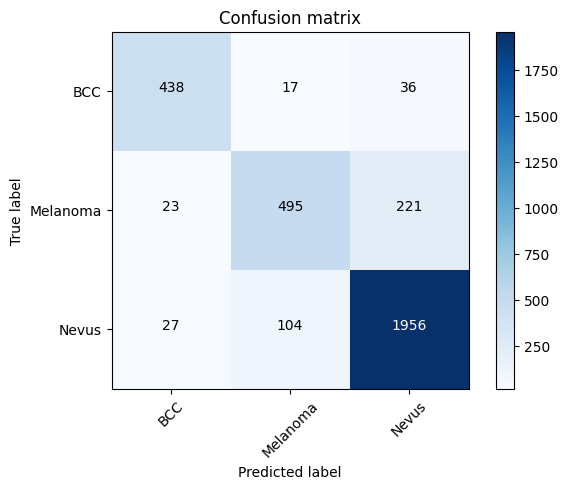

In [ ]:
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_test, axis=1)

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
BS=16
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=BS)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
predIdxs = model.predict(x_test, batch_size=BS)

#for each image in the teesting set we need to find the index of the label with
#corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

# show a nicely formatted classification report
print(classification_report(rounded_labels, predIdxs,target_names=['BCC','Melanoma','Nevus']))

208/208 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

         BCC       0.90      0.89      0.89       491
    Melanoma       0.80      0.67      0.73       739
       Nevus       0.88      0.94      0.91      2087

    accuracy                           0.87      3317
   macro avg       0.86      0.83      0.85      3317
weighted avg       0.87      0.87      0.87      3317



# Ploting ROC AUC

208/208 [==============================] - 36s 171ms/step


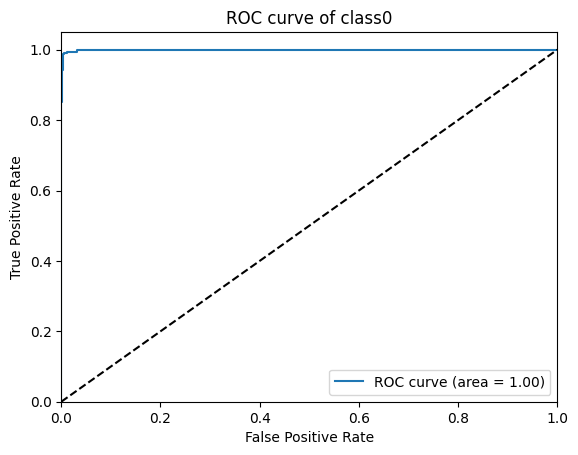

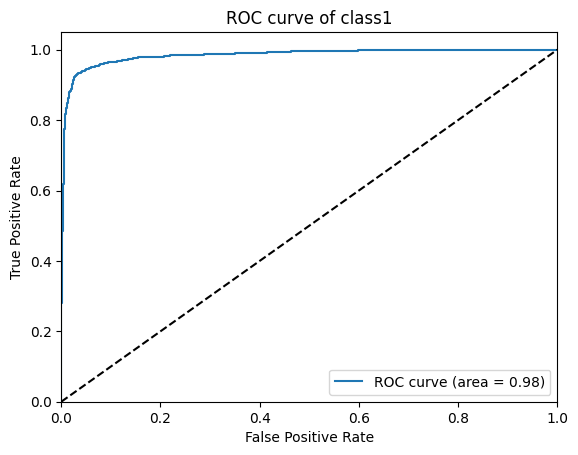

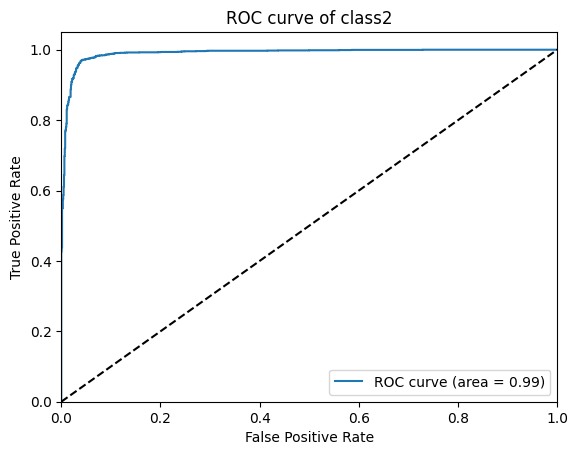

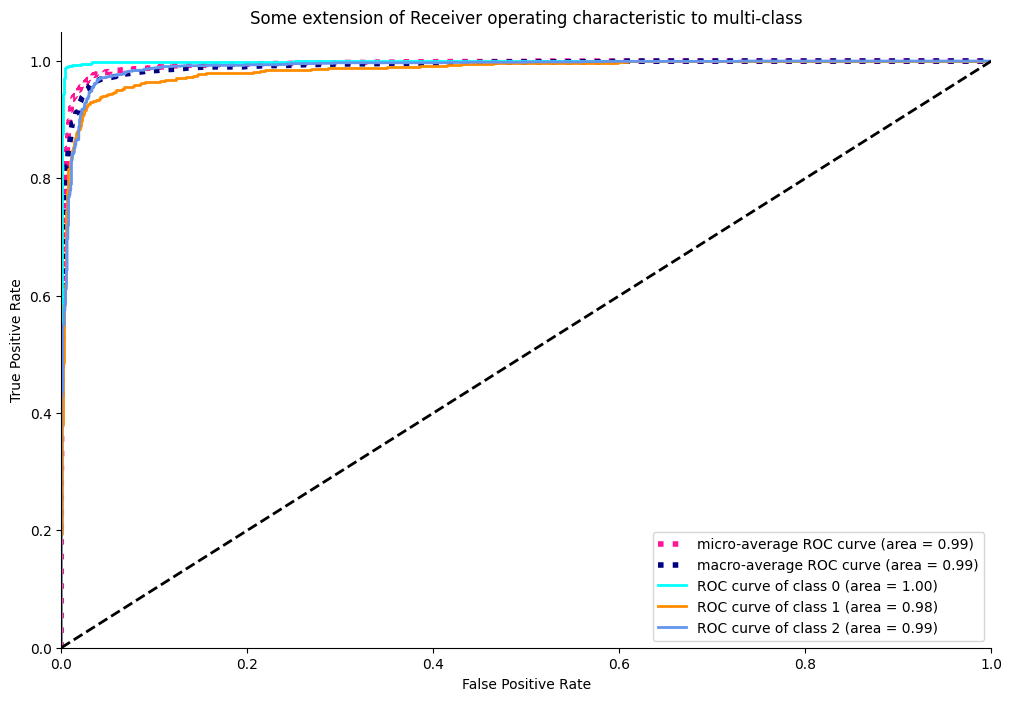

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 3

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of class'+ str(i) )
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# Test Data Preparation

In [ ]:
data=[]
labels=[]
Basal = os.listdir("/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Test/")
for a in Basal:
    try:
        image = cv2.imread("/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Test/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/MyDrive/Training_Input/Melanoma/Test/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/MyDrive/Training_Input/Melanoma/Test/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/MyDrive/Training_Input/Nevus/Test/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/MyDrive/Training_Input/Nevus/Test/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [ ]:
feats_test = np.array(data)
labels_test = np.array(labels)

np.save("/content/drive/MyDrive/Training_Input/feats_test",feats_test)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels_test",labels_test)

In [ ]:
feats_test = np.load("/content/drive/MyDrive/Training_Input/feats_test.npy")
labels_test = np.load("/content/drive/MyDrive/Training_Input/labels_test.npy")

num_classes = len(np.unique(labels_test))
len_data = len(feats_test)
print(len_data)

4145


In [ ]:
x_valid = feats_test.astype('float32')/255
y_valid = to_categorical(labels_test, 3)

In [ ]:
pred_Y= model.predict(x_valid, batch_size=10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size = 16, verbose = 0)
pred = np.argmax(rounded_predictions, axis = 1) # Returns the indices of the highest probability predictions for each data instance in the rounded_predictions array

415/415 [==============================] - 46s 111ms/step


415/415 [==============================] - 41s 100ms/step


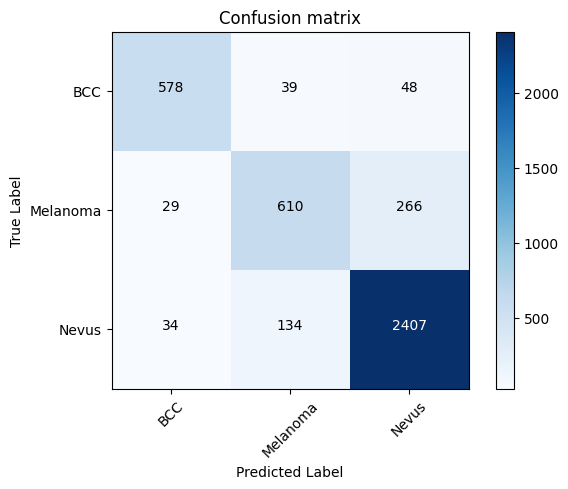

In [ ]:
Bs=10
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest',cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  target_names = ['BCC', 'Melanoma', 'Nevus']

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis]

  thresh = cm.max() / 2. # It represents half of the maximum value found in the confusion matrix. This value is used to define a threshold for determining the background colour of the squares in the confusion matrix.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j , i, cm[i,j],
             horizontalalignment="center",
             color = "white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=Bs)

# Convert predictions classes to one hot vector
Y_pred_classes = np.argmax(pred_Y, axis=1)

# Convert validation observation to one hot vectors
# Compute the confusion matrix

rounded_labels = np.argmax(y_valid, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))



In [ ]:
img1 = "/content/drive/MyDrive/Training_Input/Basal_Cell_Carcinoma/Test/BCC_ISIC_0024332.jpg"
img2 =  "/content/drive/MyDrive/Training_Input/Melanoma/Test/melanoma_ISIC_0000002.jpg"
img3 = "/content/drive/MyDrive/Training_Input/Nevus/Test/Nevus_ISIC_0000008.jpg"

In [ ]:
class_dict = {"Basal_Cell_Carcinoma":0,
              "Melanoma":1,
              "Nevus":2}

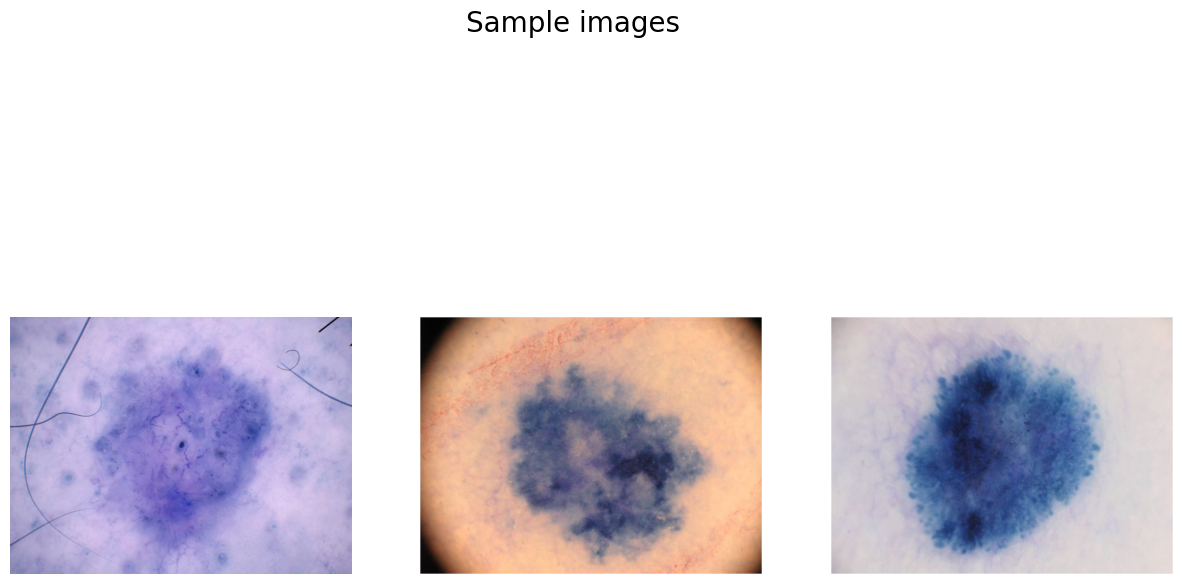

In [ ]:
f,ax = plt.subplots(1,3,figsize=(15,9))
imgs = [img1, img2, img3]

for i in range(0,3):
    im = cv2.imread(imgs[i])
    ax[i].imshow(im)
    ax[i].axis('off')
f.suptitle('Sample images',fontsize=20)
plt.show()

In [ ]:
from IPython.display import display
def pred_image(img_path, model):
  img = Image.open(img_path).resize((224,224))
  #Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)
  pred = np.argmax(preds, axis = 1)
  pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]

  return pred_cat


In [ ]:
pred_image(img2,model)

1/1 [==============================] - 0s 51ms/step


'Nevus'

104/104 [==============================] - 35s 334ms/step


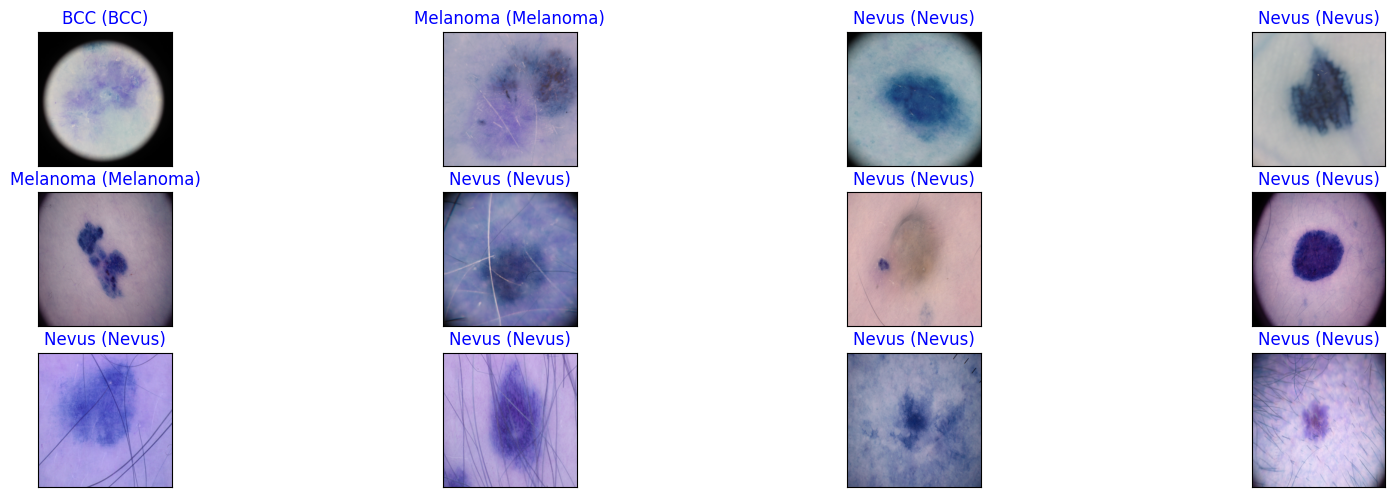

In [ ]:
y_hat = model.predict(x_test)

# Define text labels
skin_labels = ['BCC', 'Melanoma', 'Nevus']

# Plot a random sample of test images, their predicted labels and ground truth
fig = plt.figure(figsize = (20,8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 12, replace = False)):
  ax = fig.add_subplot(4, 4, i+1, xticks = [], yticks = [])
  ax.imshow(np.squeeze(x_test[idx]))
  pred_idx = np.argmax(y_hat[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
  color=("blue" if pred_idx == true_idx else "orange"))

itertools.product(range(cm.shape[0]), range(cm.shape[1])): itertools.product is a function that returns the Cartesian product of the iterables supplied to it. In this case, range(cm.shape[0]) and range(cm.shape[1]) are used to create two lists: one going from 0 to the number of rows in the confusion matrix and the other going from 0 to the number of columns in the confusion matrix. product then iterates over all possible combinations of row and column index pairs.